<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/ResNet_50_pretrained_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D


## Google Drive connection

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

models_path = "/content/drive/MyDrive/BrainTumorDataset/Models"
cnn_results_path = os.path.join(models_path, 'CNN')
vgg16_results_path = os.path.join(models_path, 'VGG16')
resnet50_results_path = os.path.join(models_path, 'ResNet50')
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')
# actual_results_path = vgg16_results_path

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 224
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5') 
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix	
	cm = confusion_matrix(y_true, y_pred)	
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)
	
	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index 

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4520 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 652 images belonging to 4 classes.


# Load ResNet-50

In [4]:
# Carica il modello ResNet50 pre-addestrato, senza l'ultimo strato fully connected
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

# Feature extraction

## Experiment 1 USE FLATTEN
ResNet-50 + dense layer 256 neuron

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 3.0913 - accuracy: 0.4462
Epoch 1: val_loss improved from inf to 1.14252, saving model to /conte

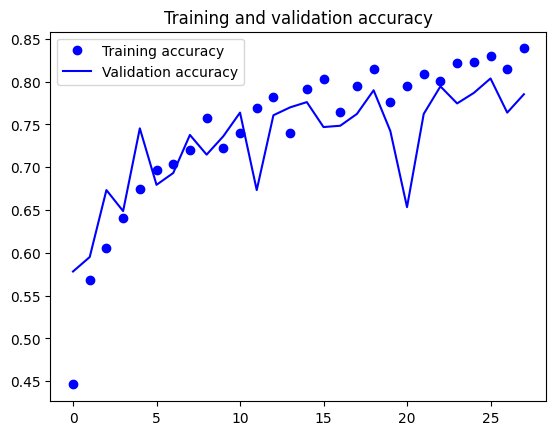

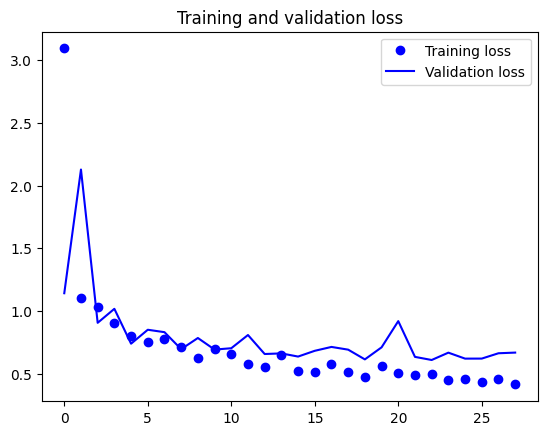

21/21 [==============================] - 179s 9s/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.9725    0.5730    0.7211       185
meningioma_tumor     0.6761    0.7701    0.7200       187
        no_tumor     0.6454    0.9100    0.7552       100
 pituitary_tumor     0.8836    0.9278    0.9051       180

        accuracy                         0.7791       652
       macro avg     0.7944    0.7952    0.7754       652
    weighted avg     0.8128    0.7791    0.7768       652



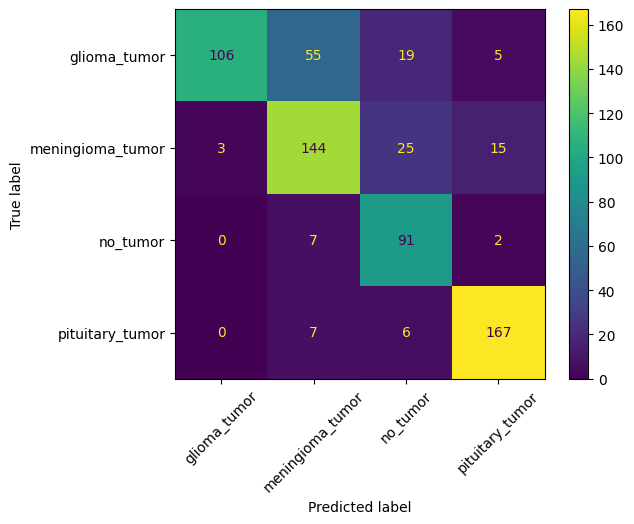

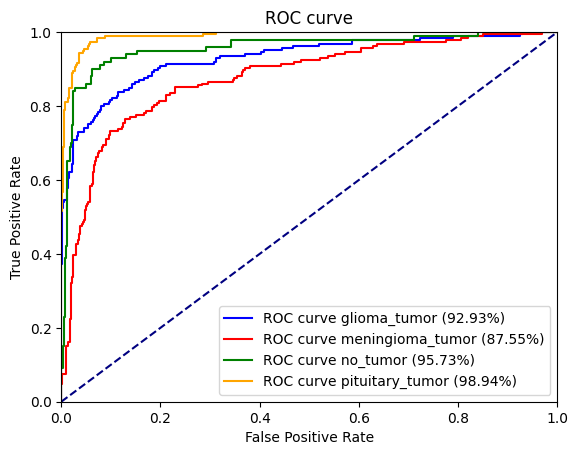

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_256")

evaluate_model(model, test_generator, "ResNet-50_256", "ResNet50")

### suggerimento : 

Se la curva di validation dell'accuracy oscilla, alza e abbassa, potrebbe essere un segnale di overfitting. Questo perché il modello sta diventando troppo complesso e si sta adattando troppo bene ai dati di addestramento. Inoltre, l'oscillazione potrebbe essere dovuta alla presenza di troppa varianza nei dati di addestramento o ad una dimensione insufficiente del dataset di addestramento.

Un altro possibile motivo per cui la curva di validation dell'accuracy oscilla potrebbe essere la sensibilità del modello alla configurazione dei dati di addestramento e di validazione. Ad esempio, se la suddivisione dei dati di addestramento e di validazione non è stata effettuata in modo casuale, potrebbe esserci una certa correlazione tra i dati di addestramento e quelli di validazione che potrebbe influenzare la performance del modello.

In generale, se la curva di validation dell'accuracy oscilla, alza e abbassa, si consiglia di utilizzare tecniche di regolarizzazione come dropout o l1/l2 regularization per ridurre l'overfitting. Inoltre, potrebbe essere utile aumentare la dimensione del dataset di addestramento o utilizzare tecniche di data augmentation per aumentare la varietà dei dati di addestramento. Infine, è possibile considerare l'utilizzo di modelli più semplici o l'ottimizzazione dei parametri del modello per migliorare le performance.

## Experiment 2
ResNet-50 + dense layer 256 neurons and dropout 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [============

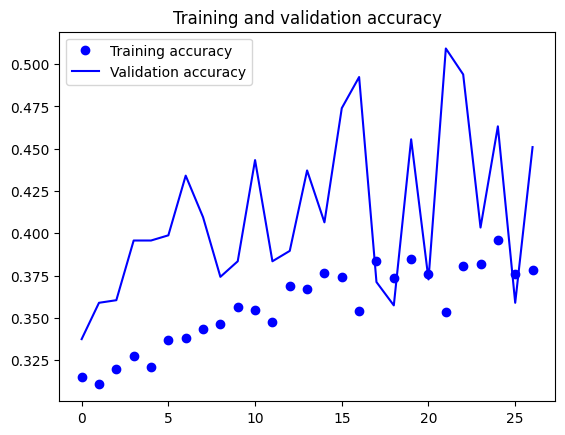

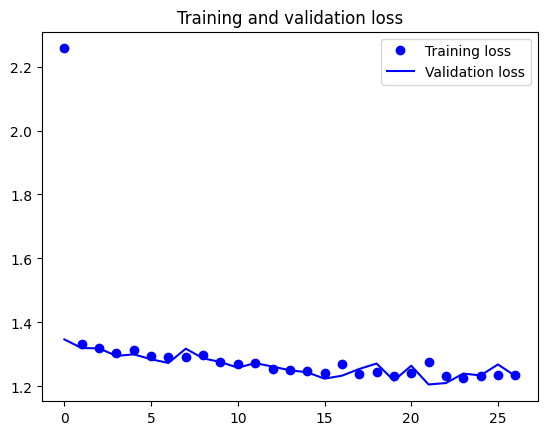

21/21 [==============================] - 6s 230ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.4884    0.1135    0.1842       185
meningioma_tumor     0.3145    0.2086    0.2508       187
        no_tumor     0.6415    0.6800    0.6602       100
 pituitary_tumor     0.4617    0.9722    0.6261       180

        accuracy                         0.4647       652
       macro avg     0.4765    0.4936    0.4303       652
    weighted avg     0.4546    0.4647    0.3983       652



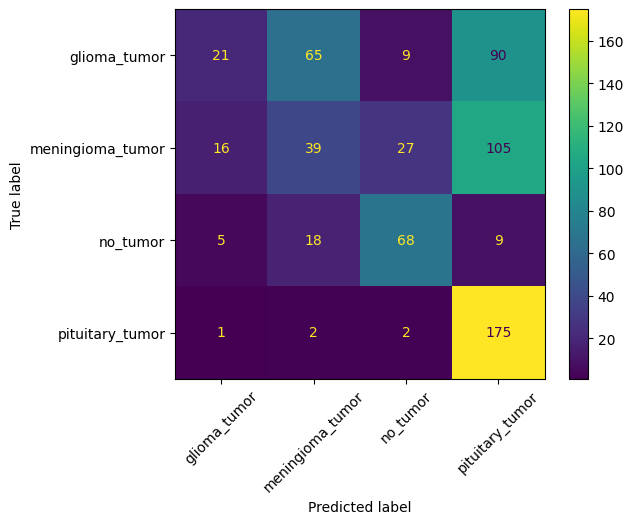

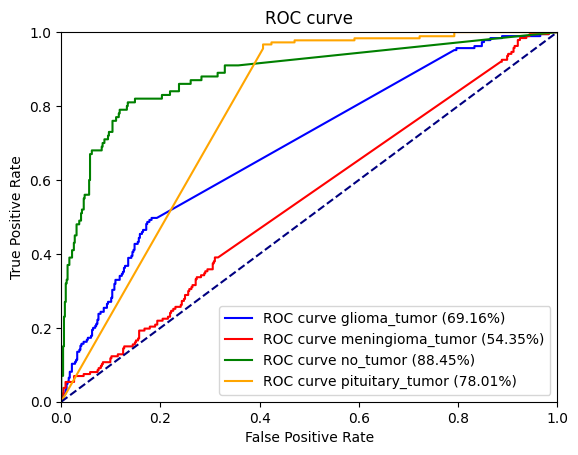

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model,'ResNet50', "ResNet-50_256_dropout")

evaluate_model(model, test_generator, "ResNet-50_256_dropout", "ResNet50")

### suggerimento: 
Se dopo aver applicato il dropout la curva di validazione è più alta di quella di training, potrebbe essere un segnale di underfitting, ovvero il modello non è abbastanza complesso per adattarsi ai dati di training.

Il dropout è una tecnica di regolarizzazione che aiuta a prevenire l'overfitting. Essa consiste nel "spegnere" in modo casuale alcuni neuroni durante l'addestramento, in modo da forzare la rete a trovare più vie per rappresentare le relazioni tra le variabili di input.

Se la curva di validazione è più alta di quella di training dopo l'applicazione del dropout, potrebbe significare che la rete non è abbastanza complessa per adattarsi ai dati di training. In questo caso, si potrebbe provare ad aumentare la complessità della rete, aggiungendo più strati o più neuroni ai layer esistenti. In alternativa, si potrebbe provare ad aumentare la dimensione del dataset di training per avere più dati con cui addestrare la rete.

## Experiment 8

2 dense layer 128 neuron + flatten()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_11 (Dense)            (None, 128)               12845184  
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 4)                 516       
                                                                 
Total params: 36,449,924
Trainable params: 12,862,212
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [============

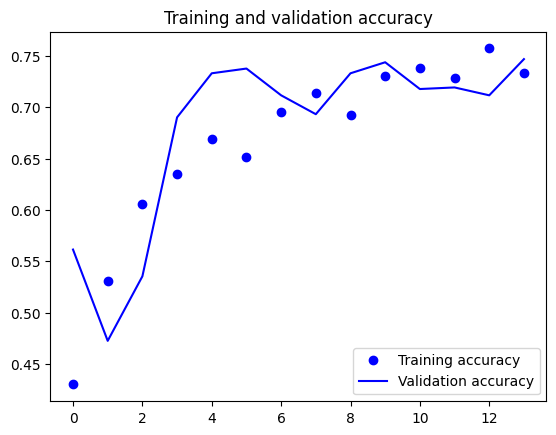

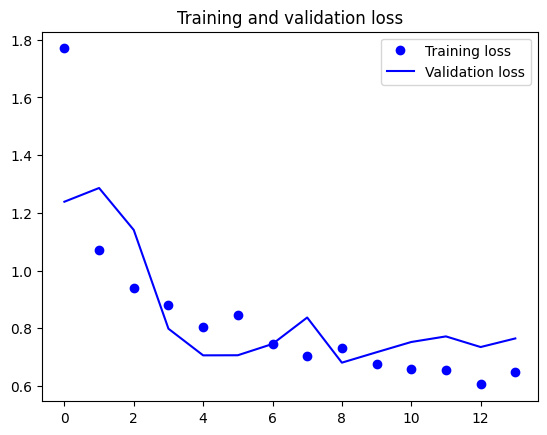

21/21 [==============================] - 5s 190ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7143    0.7027    0.7084       185
meningioma_tumor     0.6887    0.5561    0.6154       187
        no_tumor     0.5135    0.9500    0.6667       100
 pituitary_tumor     0.9627    0.7167    0.8217       180

        accuracy                         0.7025       652
       macro avg     0.7198    0.7314    0.7030       652
    weighted avg     0.7447    0.7025    0.7066       652



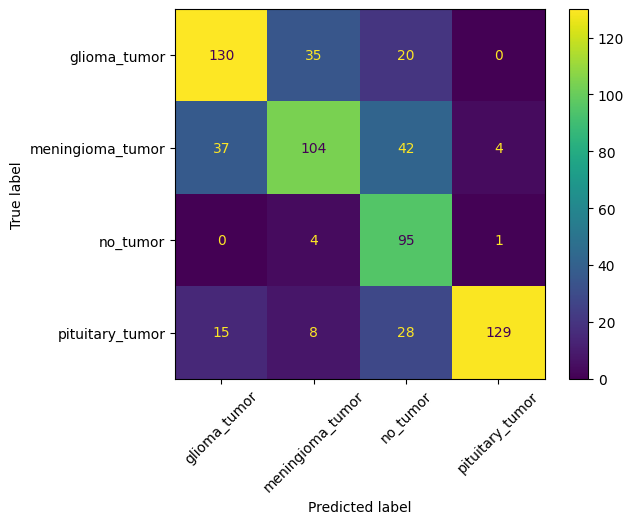

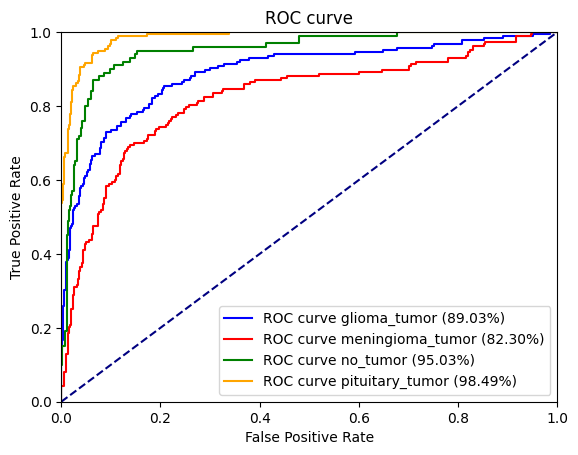

In [8]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_128")

evaluate_model(model, test_generator, "ResNet-50_128", "ResNet50")

## Experiment 4 USE GAP
ResNet-50 + dense layer 512 neuron and GlobalAveragePooling2D

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.2554 - accuracy: 0.4226
Epo

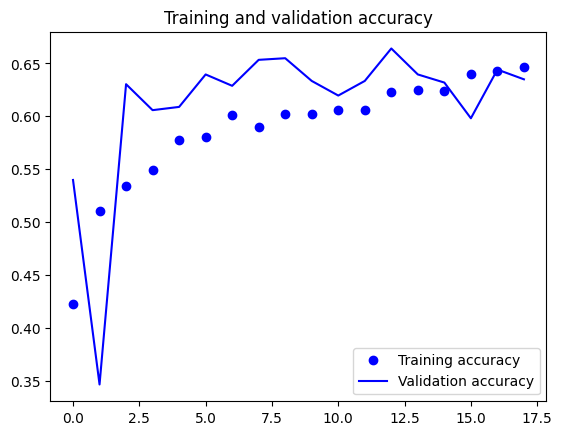

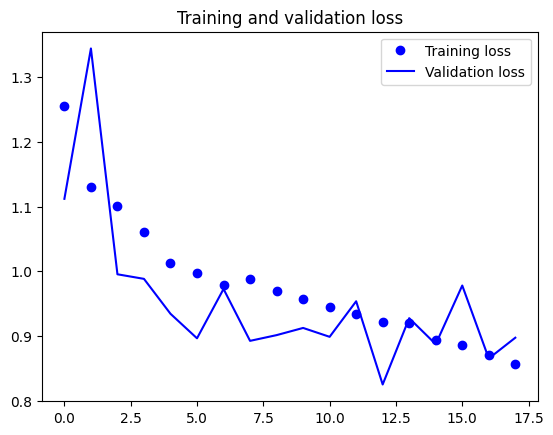

21/21 [==============================] - 6s 227ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7615    0.4486    0.5646       185
meningioma_tumor     0.4873    0.7166    0.5801       187
        no_tumor     0.5364    0.8100    0.6454       100
 pituitary_tumor     0.8889    0.5778    0.7003       180

        accuracy                         0.6166       652
       macro avg     0.6685    0.6383    0.6226       652
    weighted avg     0.6835    0.6166    0.6189       652



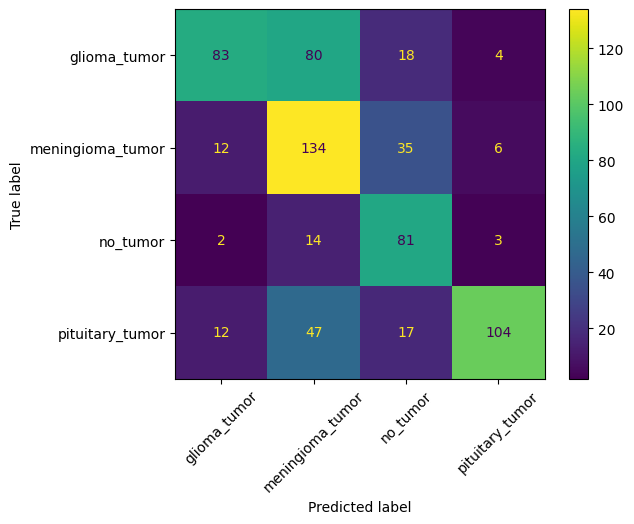

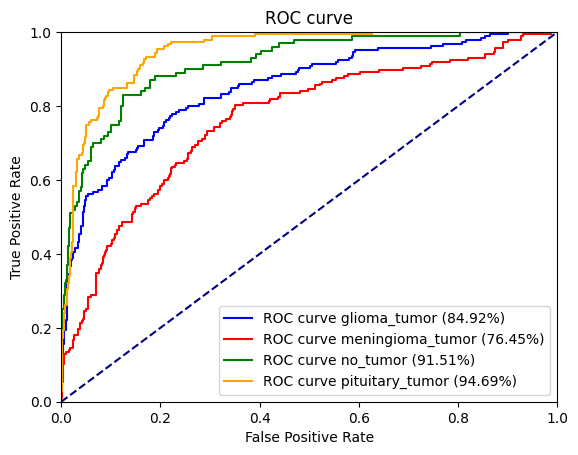

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_512_globAvgPool", "ResNet50")

## Experiment 5
ResNet-50 + dense layer 512 neuron and GlobalAveragePooling2D with dropout

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
__________________________________

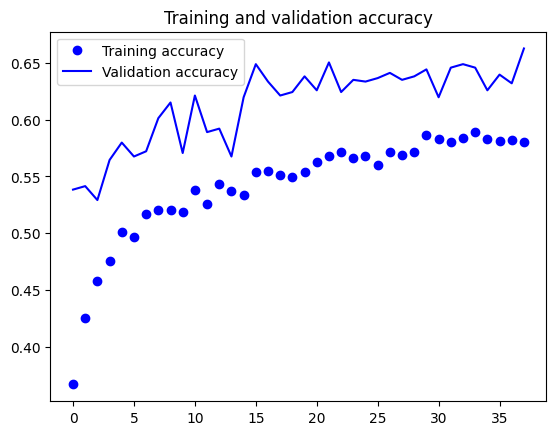

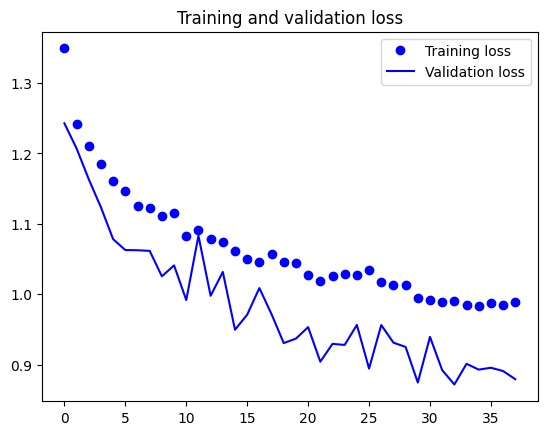

21/21 [==============================] - 5s 185ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.7256    0.6432    0.6819       185
meningioma_tumor     0.6500    0.4171    0.5081       187
        no_tumor     0.5352    0.7600    0.6281       100
 pituitary_tumor     0.6858    0.8611    0.7635       180

        accuracy                         0.6564       652
       macro avg     0.6492    0.6704    0.6454       652
    weighted avg     0.6637    0.6564    0.6464       652



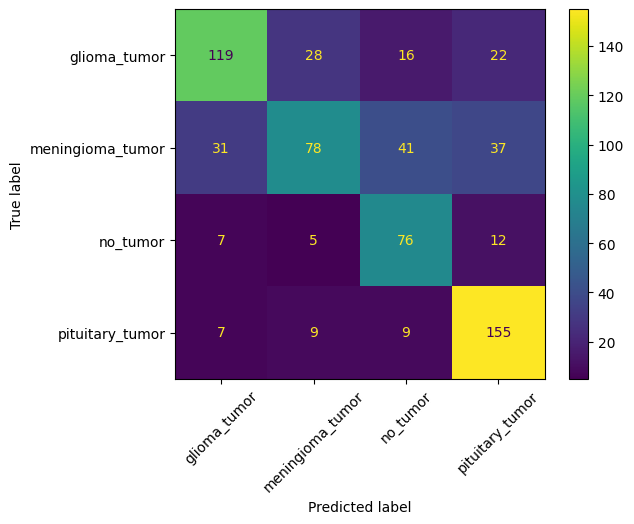

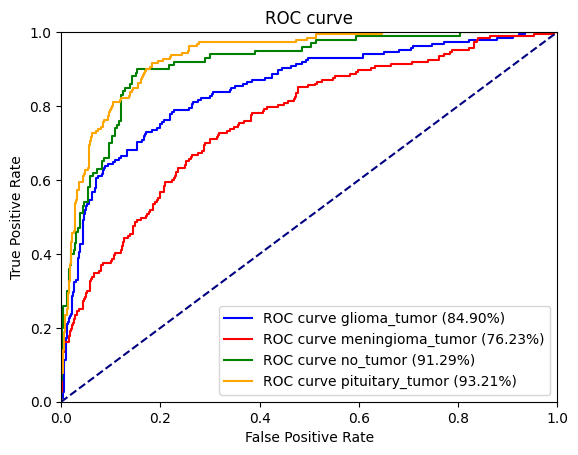

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool_dropout")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_512_globAvgPool_dropout", "ResNet50")

## Experiment 6
ResNet-50 + dense layer 128 neuron

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               262272    
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 262,788
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 1.2839 - accuracy: 0.4150
Epoch

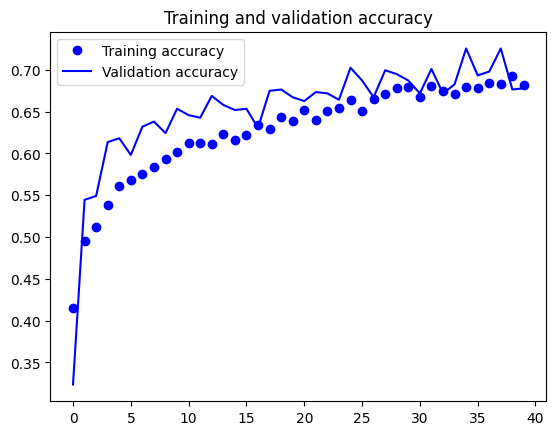

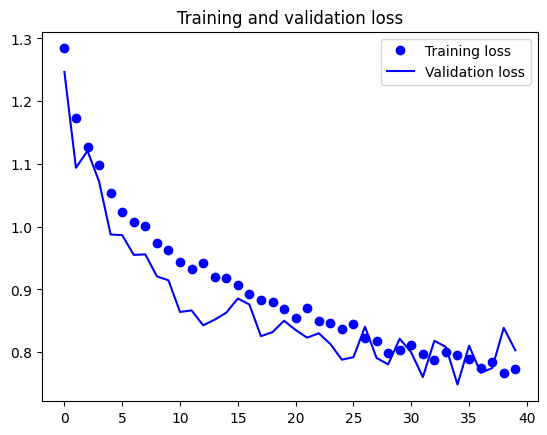

21/21 [==============================] - 6s 241ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.6224    0.6595    0.6404       185
meningioma_tumor     0.5904    0.5936    0.5920       187
        no_tumor     0.5917    0.7100    0.6455       100
 pituitary_tumor     0.8649    0.7111    0.7805       180

        accuracy                         0.6626       652
       macro avg     0.6674    0.6685    0.6646       652
    weighted avg     0.6755    0.6626    0.6660       652



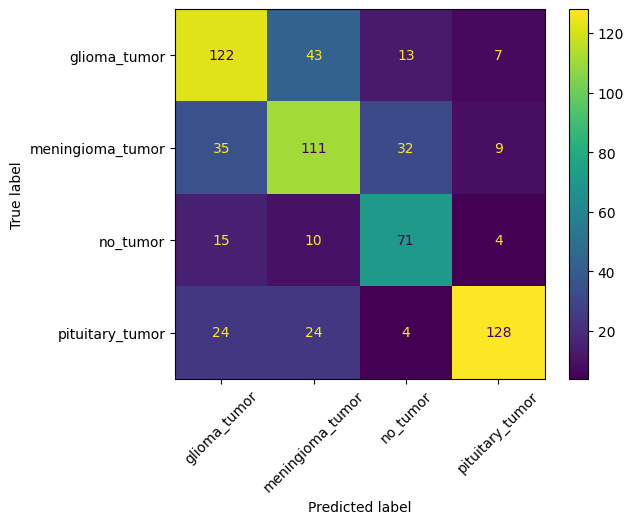

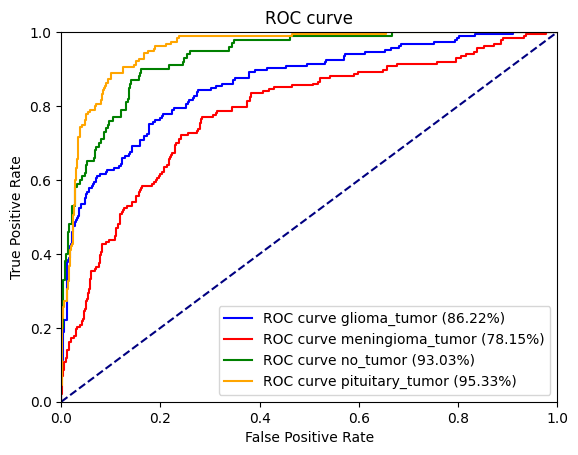

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_128_GlAvgPool")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_128_GlAvgPool", "ResNet50")

## Experiment 9
1 dense layer 128 plus 256 dense layer + glob avg pool 

In [ ]:
# Aggiungi un nuovo strato fully connected all'ultimo layer di VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) #4 classi di output

# Congela i pesi del modello base, così da mantenere l'informazione appresa
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
compile_model(model)

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_256_globAvgPool")

# Evaluate model
evaluate_model(model,test_generator, "ResNet-50_256_globAvgPool", "ResNet50")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_20 (Dense)            (None, 128)               262272    
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 4)                 516       
                                                                 
Total params: 23,867,012
Trainable params: 279,300
Non-trainable params: 23,587,712
____________________________________

# Fine Tuning

## Experiments on the previous best two attempts by removing the last convolution block.

## Experiment 1
Unlocked the last convolutional block of ResNet-50 with the first experiment.
ResNet-50 + dense layer 256 neuron.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 40,667,396
Non-trainable params: 8,611,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 5.2551 - accuracy: 0.3827
Epoch 1: val_loss improved from inf to 4.15443, saving model to /conten

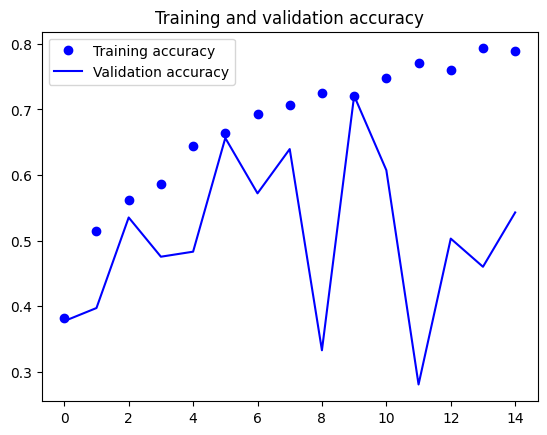

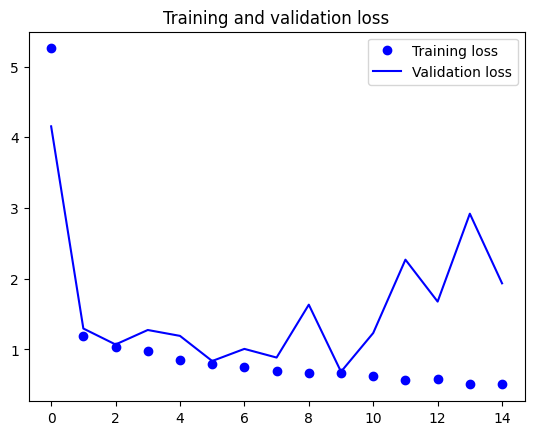

21/21 [==============================] - 6s 218ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5254    0.8378    0.6458       185
meningioma_tumor     0.8108    0.1604    0.2679       187
        no_tumor     0.3815    0.9500    0.5444       100
 pituitary_tumor     0.9577    0.3778    0.5418       180

        accuracy                         0.5337       652
       macro avg     0.6689    0.5815    0.5000       652
    weighted avg     0.7046    0.5337    0.4932       652



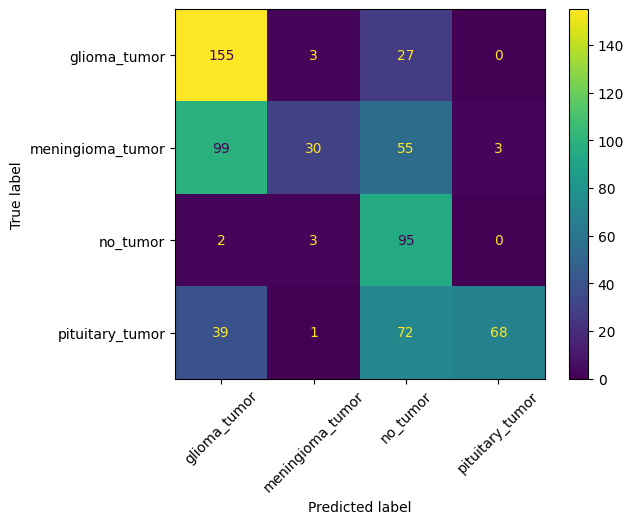

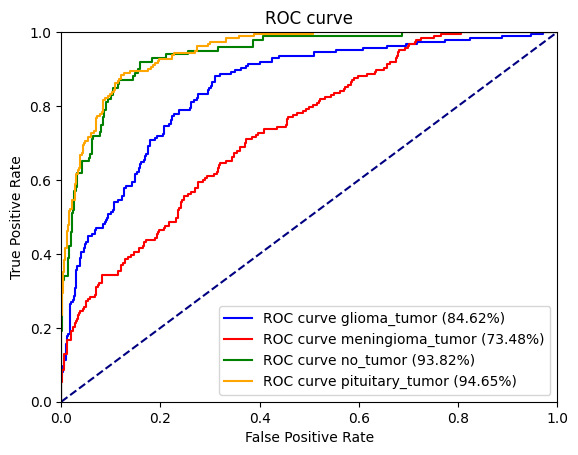

In [ ]:
models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning", "ResNet50")

## Experiment 2
Unlocked the last convolutional block of ResNet-50 with the fourth experiment. ResNet-50 + dense layer 512 + Global Avg Pooling 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 16,027,140
Non-trainable params: 8,611,712
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.2253 - accuracy: 0.4327
Epo

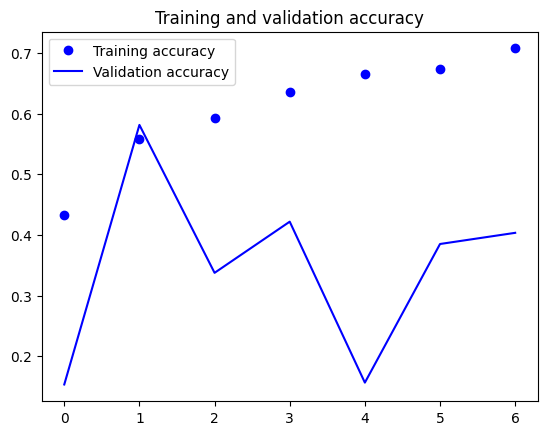

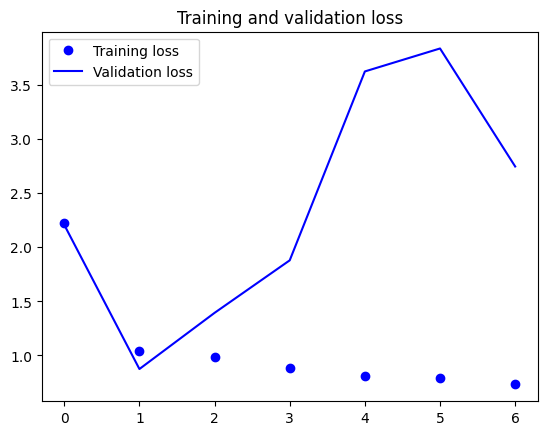

21/21 [==============================] - 5s 184ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5000    0.0378    0.0704       185
meningioma_tumor     1.0000    0.0267    0.0521       187
        no_tumor     0.5778    0.7800    0.6638       100
 pituitary_tumor     0.3594    0.9944    0.5280       180

        accuracy                         0.4126       652
       macro avg     0.6093    0.4598    0.3286       652
    weighted avg     0.6165    0.4126    0.2825       652



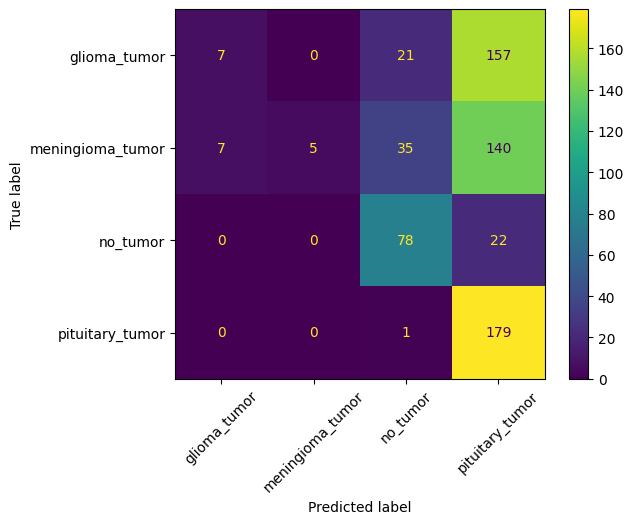

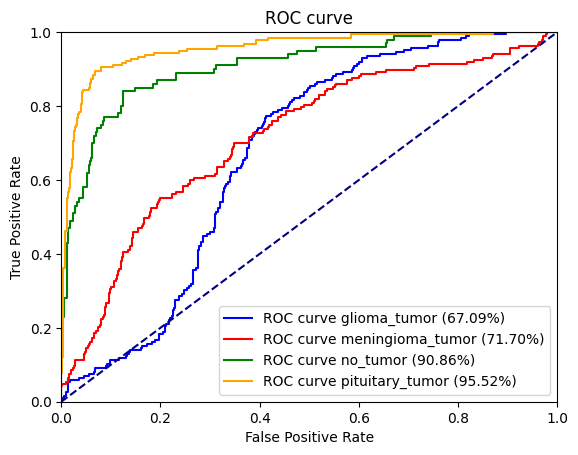

In [ ]:
models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_512_globAvgPool"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool_fine_tuning")

evaluate_model(model, test_generator, "ResNet-50_512_globAvgPool_fine_tuning", "ResNet50")

## Experiments on the previous best two attempts by removing the last convolution block and the second part of the fourth block.

## Experiment 3
Unlocked the last convolutional block of ResNet-50 plus last three convolutional layers of fourth block with the first experiment.
ResNet-50 + dense layer 256 neuron.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 44,023,556
Non-trainable params: 5,255,552
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 3.3600 - accuracy: 0.3664
Epoch 1: val_loss improved from inf to 8.41399, saving model to /conten

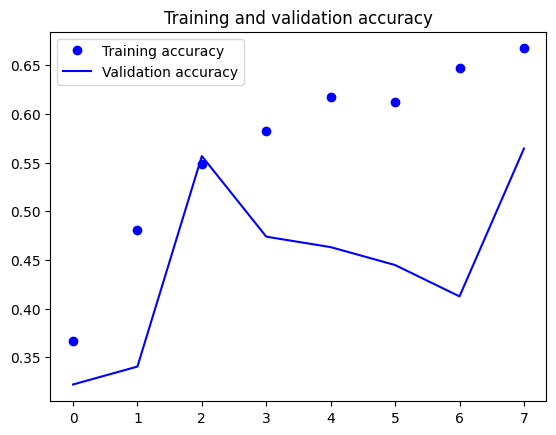

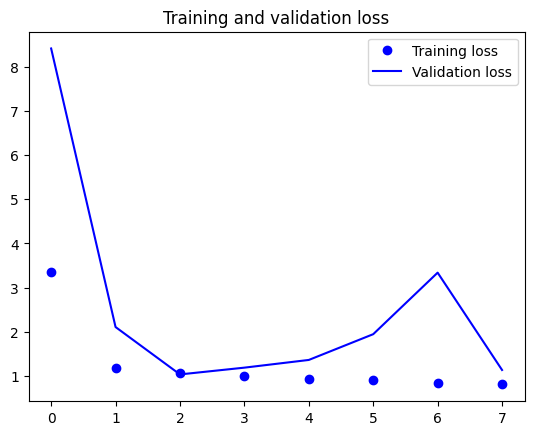

21/21 [==============================] - 6s 247ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5926    0.4324    0.5000       185
meningioma_tumor     0.4393    0.8128    0.5704       187
        no_tumor     0.7556    0.3400    0.4690       100
 pituitary_tumor     0.8095    0.5667    0.6667       180

        accuracy                         0.5644       652
       macro avg     0.6492    0.5380    0.5515       652
    weighted avg     0.6335    0.5644    0.5614       652



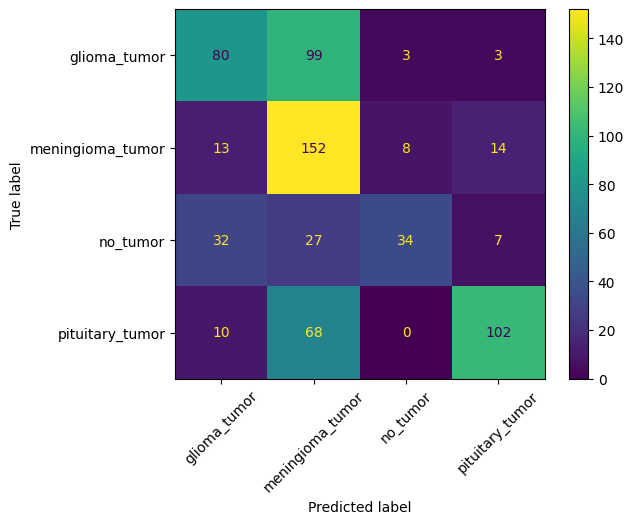

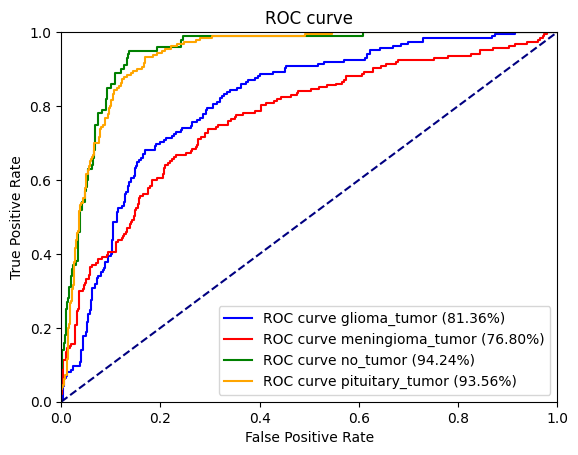

In [ ]:
models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block4_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning_2")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning_2", "ResNet50")

## Experiment 4
Unlocked the last convolutional block of ResNet-50 plus last three convolutional layers of fourth block with the fourth experiment. ResNet-50 + dense layer 512 + Global Avg Pooling 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 19,383,300
Non-trainable params: 5,255,552
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.3731 - accuracy: 0.4268
Epo

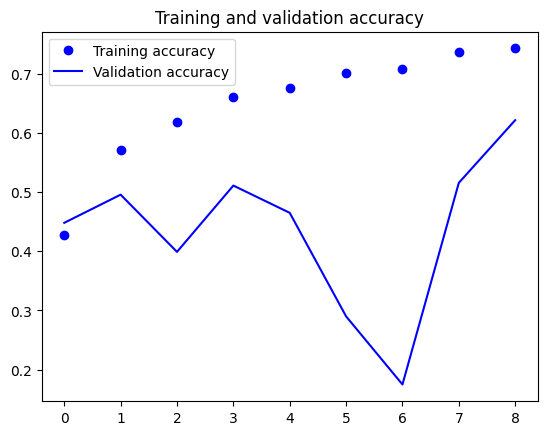

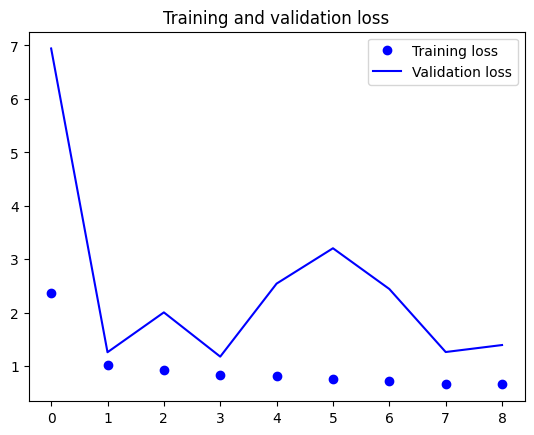

21/21 [==============================] - 5s 183ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.4832    0.9351    0.6372       185
meningioma_tumor     0.4865    0.0963    0.1607       187
        no_tumor     0.8852    0.5400    0.6708       100
 pituitary_tumor     0.7908    0.8611    0.8245       180

        accuracy                         0.6135       652
       macro avg     0.6614    0.6081    0.5733       652
    weighted avg     0.6307    0.6135    0.5574       652



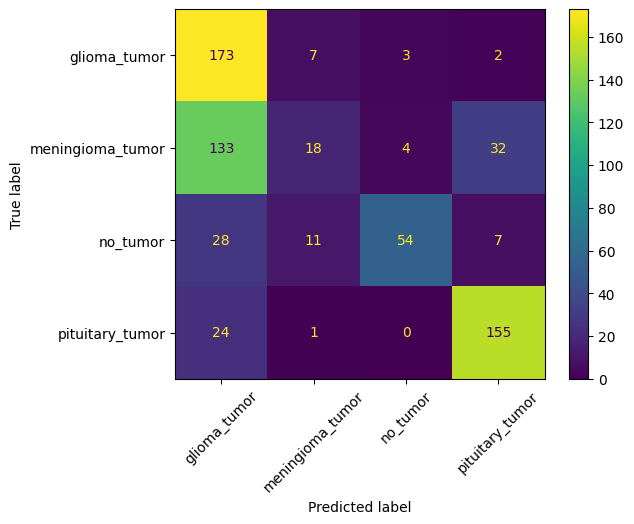

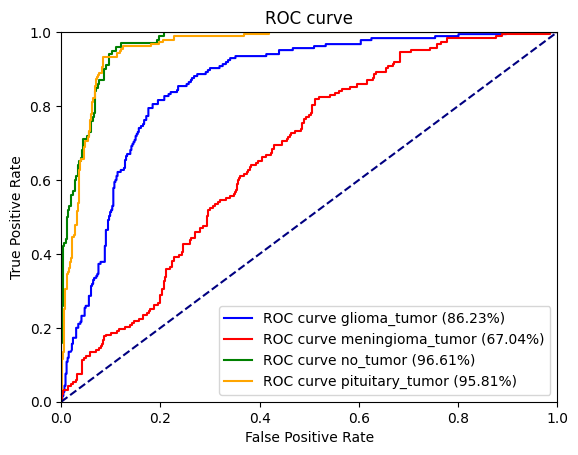

In [ ]:
models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_512_globAvgPool"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block4_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool_fine_tuning_2")

evaluate_model(model, test_generator, "ResNet-50_512_globAvgPool_fine_tuning_2", "ResNet50")

## Experiments on the previous best two attempts by removing the last convolutional layer into last convolutional block.

## Experiment 5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 30,157,060
Non-trainable params: 19,122,048
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.5963 - accuracy: 0.4465
Epoch 1: val_loss improved from inf to 1.97883, saving model to /conte

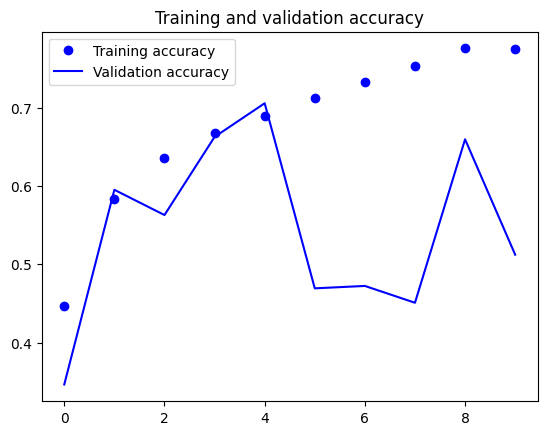

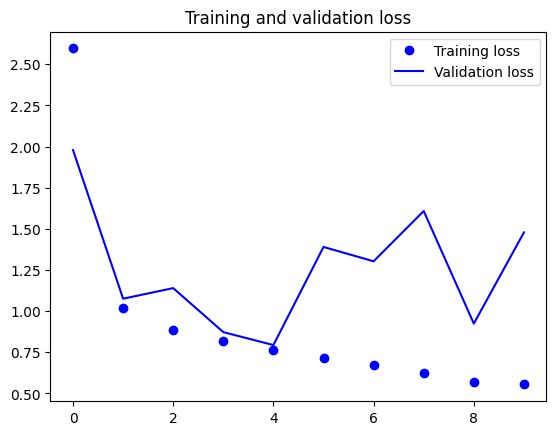

21/21 [==============================] - 6s 223ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.8125    0.3514    0.4906       185
meningioma_tumor     0.7619    0.1711    0.2795       187
        no_tumor     0.7912    0.7200    0.7539       100
 pituitary_tumor     0.4100    1.0000    0.5816       180

        accuracy                         0.5353       652
       macro avg     0.6939    0.5606    0.5264       652
    weighted avg     0.6836    0.5353    0.4955       652



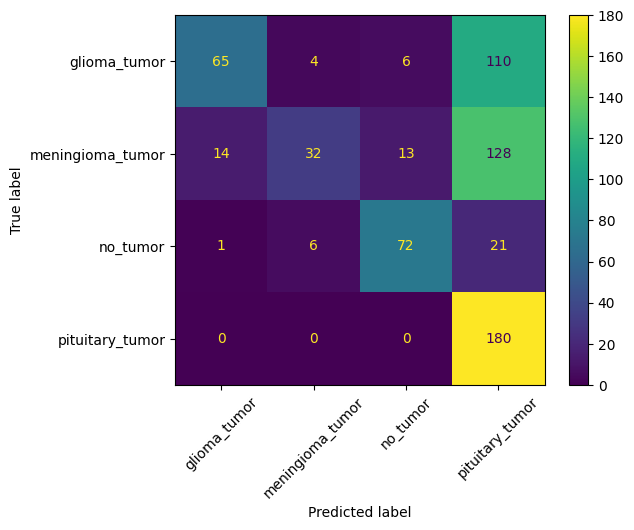

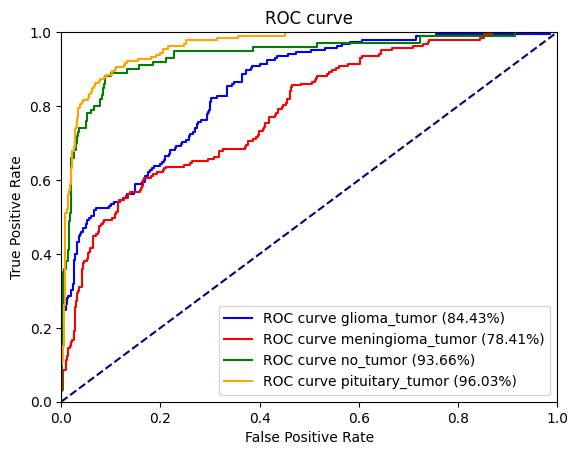

In [ ]:
models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_256"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_256_fine_tuning_3")

evaluate_model(model, test_generator, "ResNet-50_256_fine_tuning_3", "ResNet50")

## Experiment 6

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 19,383,300
Non-trainable params: 5,255,552
_________________________________________________________________
Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.2794 - accuracy: 0.4204
Epo

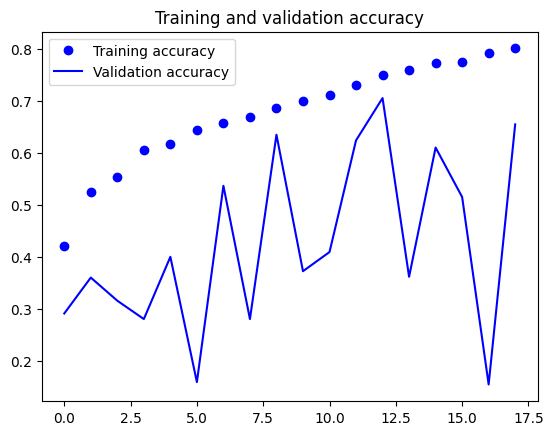

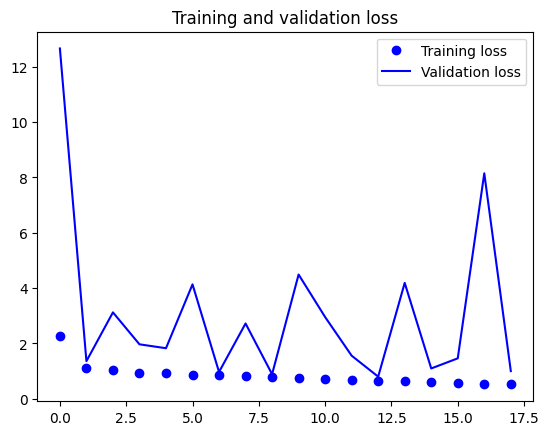

21/21 [==============================] - 6s 245ms/step
Classification report: 
                  precision    recall  f1-score   support

    glioma_tumor     0.5046    0.8973    0.6459       185
meningioma_tumor     0.7317    0.1604    0.2632       187
        no_tumor     0.5749    0.9600    0.7191       100
 pituitary_tumor     0.9478    0.6056    0.7390       180

        accuracy                         0.6150       652
       macro avg     0.6897    0.6558    0.5918       652
    weighted avg     0.7029    0.6150    0.5731       652



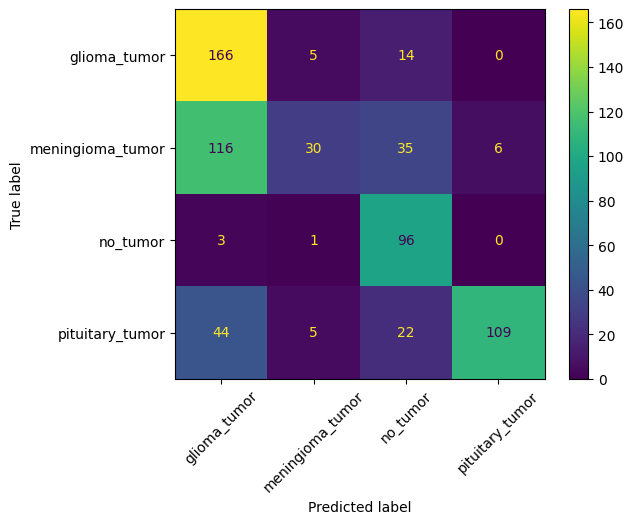

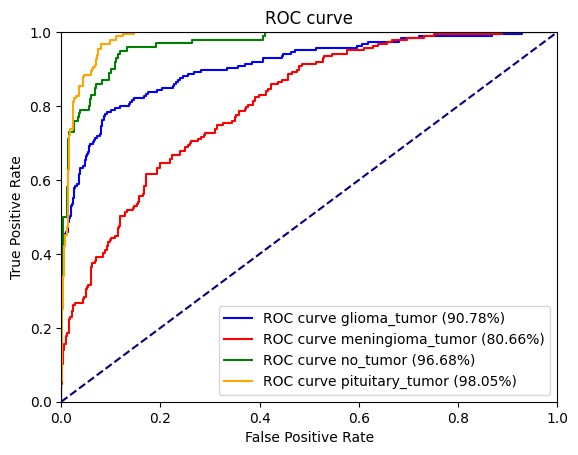

In [ ]:
models_path = dataset_path + "/Models/ResNet50/"
model_name = "ResNet-50_512_globAvgPool"

model = tf.keras.models.load_model(models_path  + model_name + ".h5")

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block4_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model) # da rivedere

# Addestra il modello
run_model(model, 'ResNet50', "ResNet-50_512_globAvgPool_fine_tuning_3")

evaluate_model(model, test_generator, "ResNet-50_512_globAvgPool_fine_tuning_3", "ResNet50")